In [1]:
from speakerbox_analysis.analysis.main import run
import matplotlib.pyplot as plt
import seaborn as sns

results = run("annotated-dataset/")
results.stats

/home/eva/miniforge-pypy3/envs/speakerbox-analysis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing speaking time statistics: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:35<00:00,  6.11it/s]


,name,sum_,mean_,median_,max_,std_,count_,session_id
0,gonzalez,119.522,4.597000,3.4870,13.847,3.837622,26,de9d821a3aba
1,juarez,344.078,6.746627,5.3050,18.785,4.846975,51,de9d821a3aba
2,None,482.878,6.898257,5.3560,32.732,6.435439,70,de9d821a3aba
3,strauss,41.875,8.375000,8.6090,13.947,3.916322,5,de9d821a3aba
4,herbold,386.654,8.991953,8.0750,24.324,5.911938,43,de9d821a3aba
...,...,...,...,...,...,...,...,...
2058,lewis,1.034,1.034000,1.0340,1.034,0.000000,1,b7286476b38f
2059,juarez,19.388,2.423500,2.1525,4.337,1.221980,8,b7286476b38f
2060,morales,108.276,3.281091,2.1020,12.245,3.010403,33,b7286476b38f
2061,gonzalez,102.401,4.876238,3.4370,17.851,4.352638,21,b7286476b38f


In [2]:
gender_lut = {
    "gonzalez": "women",
    "juarez": "women",
    "strauss": "men",
    "herbold": "women",
    "morales": "women",
    "lewis": "men",
    "pedersen": "men",
    "sawant": "women",
    "mosqueda": "women",
}
results.sparse_timeseries["gender"] = results.sparse_timeseries.speaker.apply(lambda s: gender_lut.get(s, "None"))
results.filled_timeseries["gender"] = results.filled_timeseries.speaker.apply(lambda s: gender_lut.get(s, "None"))

In [3]:
def kdeplot(data, cat_col, val_col):
    sns.set_theme(style="dark", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(15, rot=-.6, light=.6)
    g = sns.FacetGrid(data, row=cat_col, hue=cat_col, aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, val_col,
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, val_col, clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, val_col)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    return g

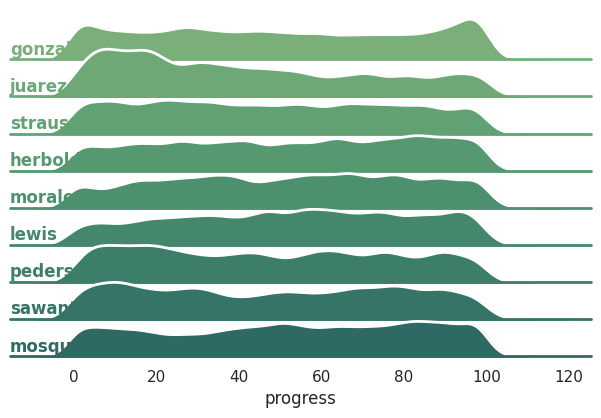

In [4]:
drop_none = results.sparse_timeseries.loc[results.sparse_timeseries.speaker != "None"]
kdeplot(drop_none, "speaker", "progress")
plt.savefig("kde-progress-occurances-all.png", bbox_inches="tight")

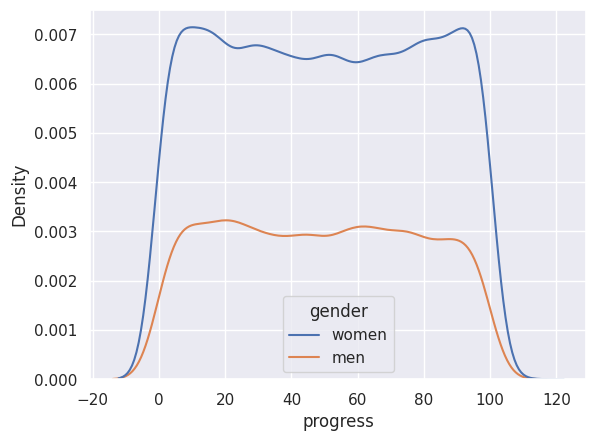

In [5]:
sns.set_theme(color_codes=True)
none_removed = results.sparse_timeseries.loc[results.sparse_timeseries.gender != "None"]
sns.kdeplot(none_removed, x="progress", hue="gender")
plt.savefig("kde-progress-occurances-gendered.png", bbox_inches="tight")

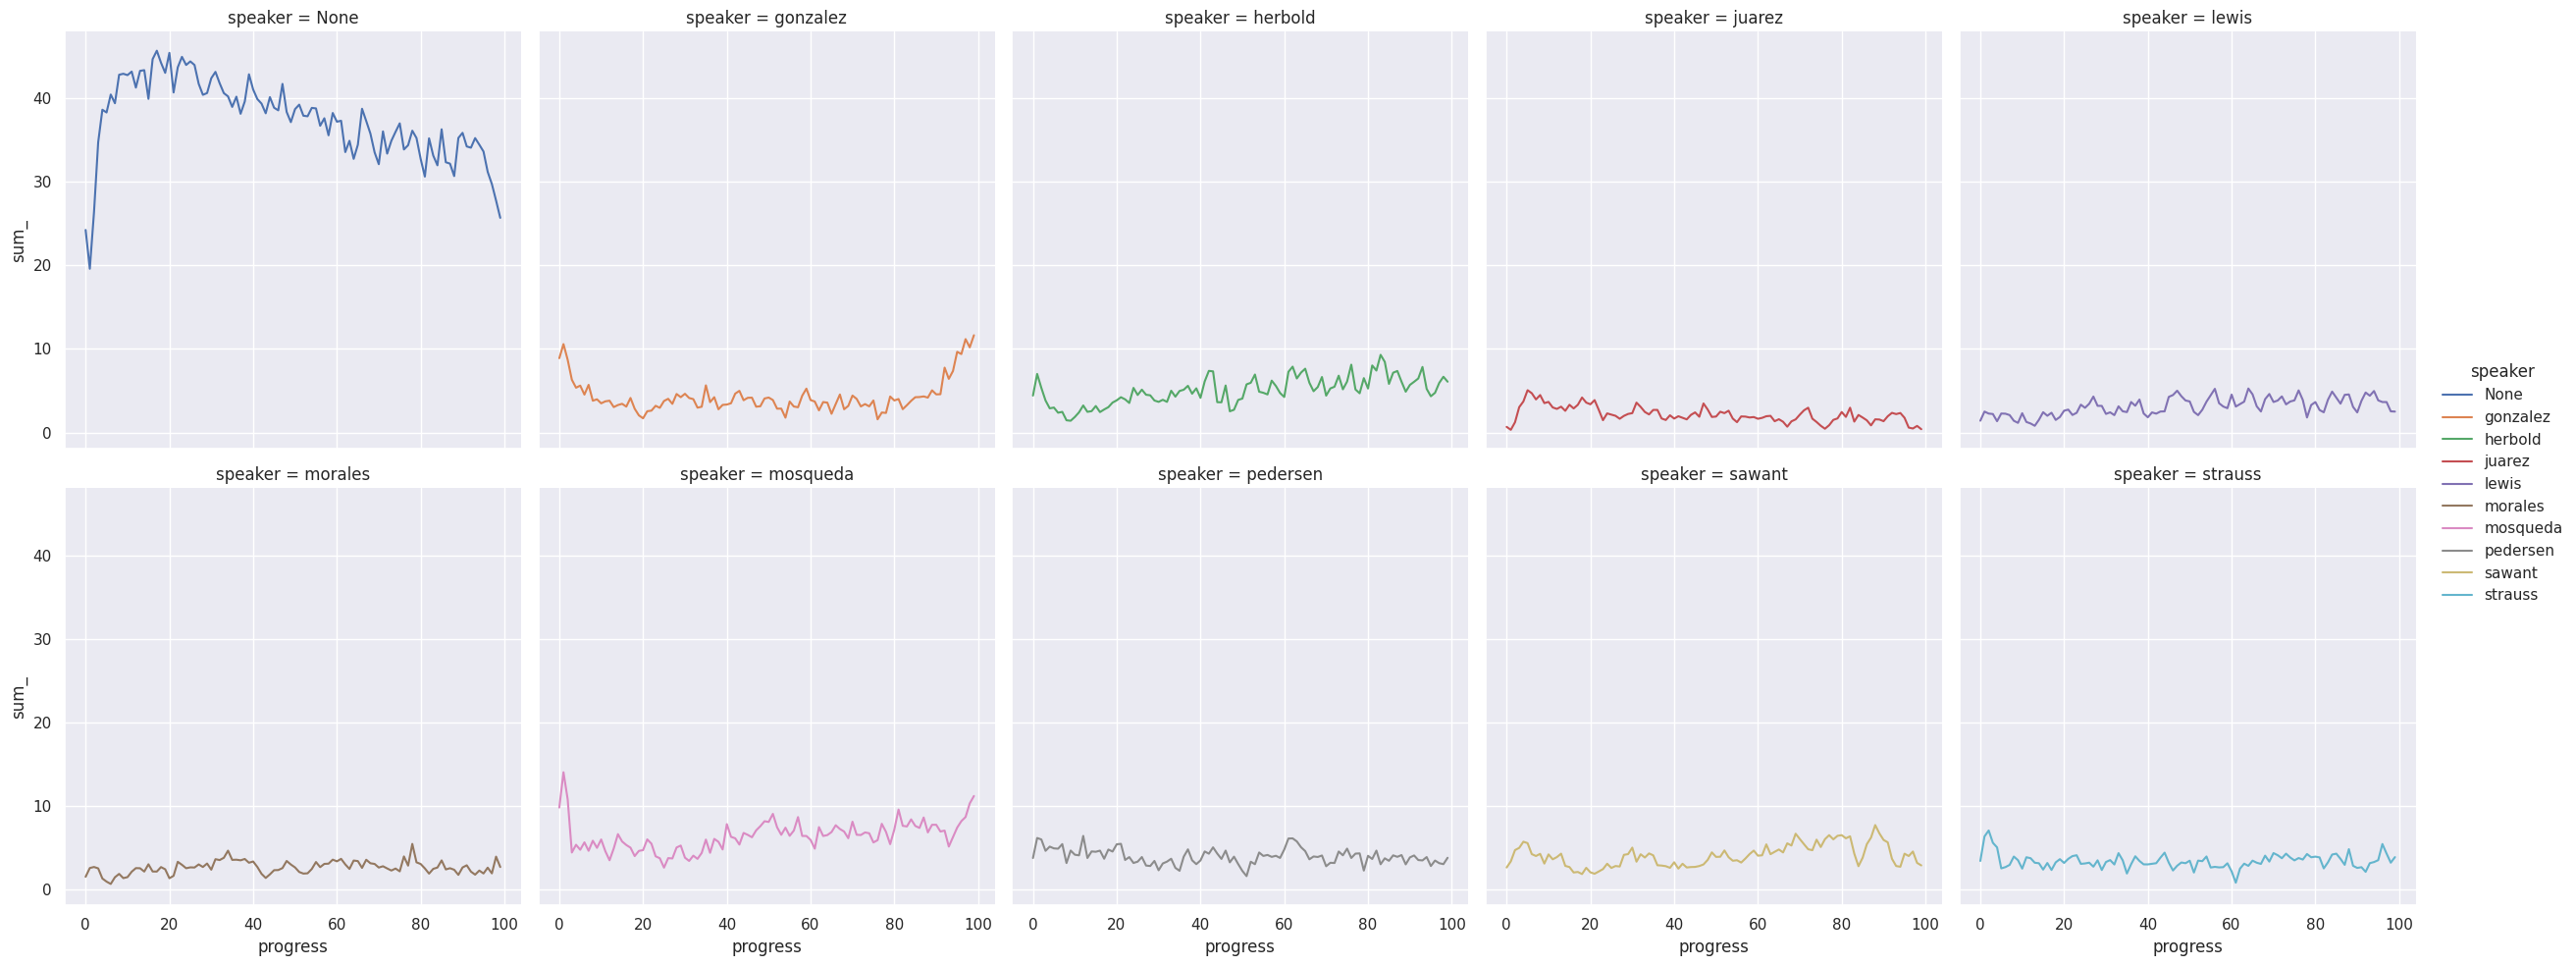

In [6]:
selected_cols = results.filled_timeseries[["speaker", "progress", "sum_"]]
mean_sum = selected_cols.groupby(["speaker", "progress"]).agg("mean").reset_index()

sns.relplot(data=mean_sum, x="progress", y="sum_", col="speaker", hue="speaker", kind="line", col_wrap=5)
plt.savefig("mean-windowed-speaking-time.png", bbox_inches="tight")

In [7]:
selected_cols = results.filled_timeseries[["gender", "progress", "sum_"]]
selected_cols = selected_cols.loc[selected_cols.gender != "None"]
mean_sum = selected_cols.groupby(["gender", "progress"]).agg("mean").reset_index()
mean_sum["adjusted_sum_"] = mean_sum.apply(lambda r: r.sum_ / 6 if r.gender == "women" else r.sum_ / 3, axis=1)

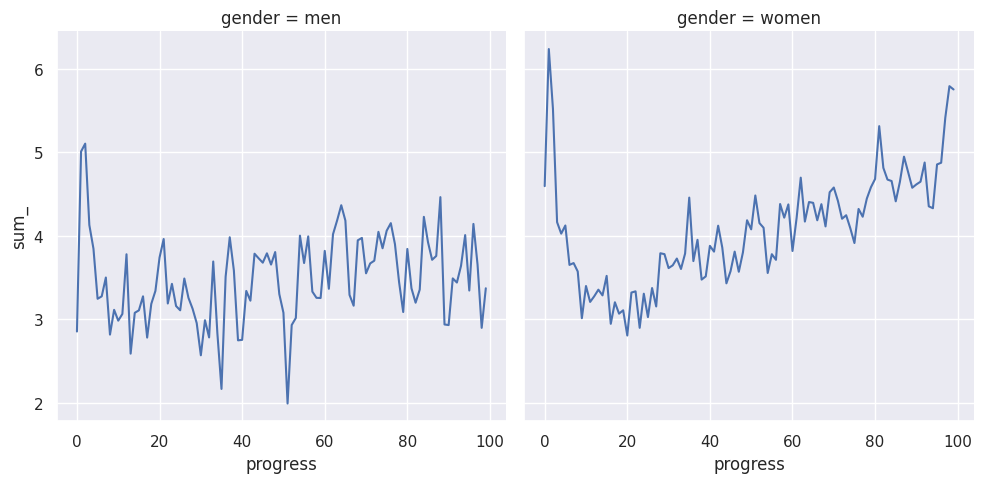

In [8]:
sns.relplot(data=mean_sum, x="progress", y="sum_", col="gender", kind="line")
plt.savefig("mean-windowed-speaking-time-gendered.png", bbox_inches="tight")

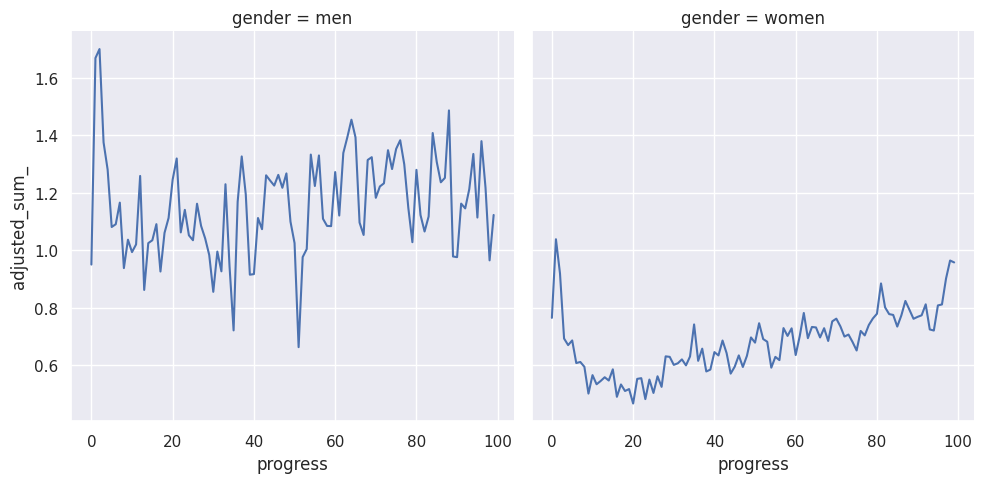

In [9]:
sns.relplot(data=mean_sum, x="progress", y="adjusted_sum_", col="gender", kind="line")
plt.savefig("mean-windowed-speaking-time-gendered-normalized.png", bbox_inches="tight")